# 1. Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
import scipy

# IMPORT CUSTOM MODULES
import sys
sys.path.append("../")
from BAMVAE.MNISTLoader import MNIST_Loader
from BAMVAE.VAE1 import VAE, loss_function,complete_train_and_test,decompose_loss_function

%load_ext autoreload
%autoreload 2

/opt/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Load data & define DataLoaders

In [2]:
device = torch.device("mps") # GPU acceleration for Mac

In [3]:
mnist=MNIST_Loader(bs=128,
    root_folder='../mnist_data')

train_dataset,test_dataset=mnist.__getdatasets__()
train_loader,test_loader=mnist.__getdataloaders__()

# 3. Define model

In [6]:
learning_rate=1e-3
nb_epochs=20
# vae=VAE(name=f"VAE_{nb_epochs}_epochs",z_dim=3).to(device)
# optimizer= optim.Adam(vae.parameters(),lr=learning_rate)
params_list=[k for k in range(10)]

# dic_VAE={
#     5: dict(vae=VAE(name="VAE_5_epochs").to(device)),

#     10: dict(vae=VAE(name="VAE_10_epochs").to(device)),
#     20: dict(vae=VAE(name="VAE_20_epochs").to(device))
#     }
# for nb_epochs in dic_VAE.keys():
#     vae=dic_VAE[nb_epochs]["vae"]
#     dic_VAE[nb_epochs]["optimizer"]= optim.Adam(vae.parameters(),lr=learning_rate)


In [7]:
# images to plot the latent space at the end of training
visualisation_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1024*2, shuffle=False)

for k,(test_images, test_labels) in enumerate(visualisation_loader):  
    if k==1:
        break

## 3. Training the models

In [8]:
nb_params=10
dic_models={}
nb_epochs=20
for k in range(nb_params):
    print("---"*10)
    print(f"Training model {k}/{nb_params}",end="\n")
    k1=k/nb_params
    k2=(nb_params-k)/nb_params
    dic_models[k]={"vae":VAE(z_dim=2,name=f"params_{k}").to(device)}
    dic_models[k]["optimizer"]= optim.Adam(dic_models[k]["vae"].parameters(),
                    lr=learning_rate)
    ### train the model with the above parameters
    losses=complete_train_and_test(dic_models[k]["vae"],train_loader=train_loader,
                    test_loader=test_loader,optimizer=dic_models[k]["optimizer"],
                    nb_epochs=nb_epochs,view_latent=False,test_dataset=test_dataset)
    # saving the models
    dic_models[k]["vae"].save_model(model_path=f"../models/varying_loss_par/reco={k1}_kld={k2}.h5")
    ### evaluate the models performance
    dic_models[k]["losses"]=losses
    ### evaluate the models FID
    ### keep track of the losses to plot in the end
    ### View the latent space

    dic_models[k]["vae"].eval()
    test_images=test_images.to(device)
    # data = data.to(device)
    # recon, mu, log_var = dic_models[k]["vae"](data)
    with torch.no_grad():
        avg,_=dic_models[k]["vae"].encoder(test_images)
    avg=avg.cpu().numpy()
    dic_models[k]["avg"]=avg
    np.save(f"../latent_space_view/latent_reco={k1}_kld={k2}.npy")

    ### TODO : keep track of both crossentropy loss and the KLD
    

------------------------------
Training model 0/10
Train Epoch: 1 [0/60000 (0%)]	Loss: 305.441254
Train Epoch: 1 [12800/60000 (21%)]	Loss: 98.084175
Train Epoch: 1 [25600/60000 (43%)]	Loss: 94.653015
Train Epoch: 1 [38400/60000 (64%)]	Loss: 91.579842
Train Epoch: 1 [51200/60000 (85%)]	Loss: 85.903999
====> Epoch: 1 Average loss: 102.8528
====> Test set loss: 87.7228
Train Epoch: 2 [0/60000 (0%)]	Loss: 89.544373
Train Epoch: 2 [12800/60000 (21%)]	Loss: 85.671043
Train Epoch: 2 [25600/60000 (43%)]	Loss: 89.063400
Train Epoch: 2 [38400/60000 (64%)]	Loss: 82.771797
Train Epoch: 2 [51200/60000 (85%)]	Loss: 79.923103
====> Epoch: 2 Average loss: 85.6873
====> Test set loss: 83.9931
Train Epoch: 3 [0/60000 (0%)]	Loss: 83.612267
Train Epoch: 3 [12800/60000 (21%)]	Loss: 84.924278
Train Epoch: 3 [25600/60000 (43%)]	Loss: 83.059151
Train Epoch: 3 [38400/60000 (64%)]	Loss: 79.589096
Train Epoch: 3 [51200/60000 (85%)]	Loss: 84.986626
====> Epoch: 3 Average loss: 83.1076
====> Test set loss: 82.3823

### 3.1 Create random images and save them in order to evaluate the FID

In [19]:
import os
os.listdir("../models/varying_loss_par/")

['params_k.h5']

In [21]:
# generating random images and saving thems
for k in range(nb_params):
    print(f"Going through param set {k}/{nb_params}")
    k1=k/nb_params
    k2=(nb_params-k)/nb_params
    images_recon=dic_models[k]["vae"].generate_images(nb_images=1024)
    np.save(f"../generated_data/generated_reco={k1}_kld={k2}.npy",images_recon)
    
    

    ### View of the latent space
    dic_models[k]["vae"].eval()
    test_images=test_images.to(device)
    # data = data.to(device)
    # recon, mu, log_var = dic_models[k]["vae"](data)
    with torch.no_grad():
        avg,_=dic_models[k]["vae"].encoder(test_images)
    avg=avg.cpu().numpy()
    dic_models[k]["avg"]=avg
    np.save(f"../latent_space_view/latent_reco={k1}_kld={k2}.npy",avg)



Going through param set 0/10
Going through param set 1/10
Going through param set 2/10
Going through param set 3/10
Going through param set 4/10
Going through param set 5/10
Going through param set 6/10
Going through param set 7/10
Going through param set 8/10
Going through param set 9/10


## 4. Visualisation of the loss

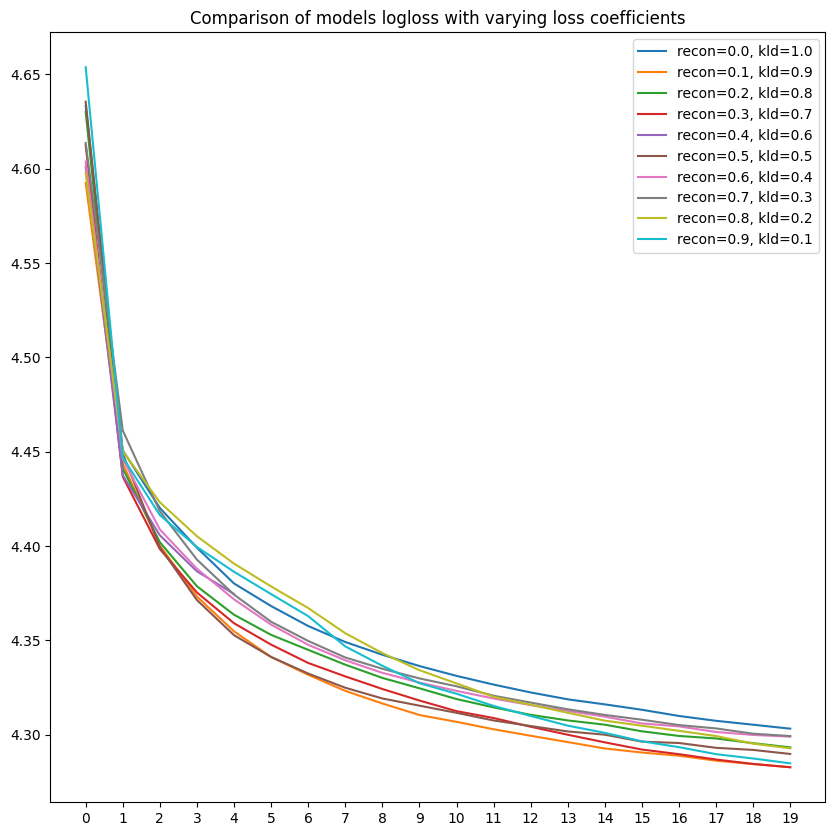

In [32]:
plt.figure(figsize=(10,10))
for k in range(nb_params):
    k1=k/nb_params
    k2=(nb_params-k)/nb_params
    plt.xticks(range(nb_epochs))
    loss=dic_models[k]["losses"]
    loss=np.log(dic_models[k]["losses"])
    a=plt.plot(loss,label=f"recon={k1}, kld={k2}")
plt.legend()

plt.title('Comparison of models logloss with varying loss coefficients')
# plt.savefig("../images/Comparison of models logloss with varying loss coefficients.png")

## 5. Visualisation of the different reconstrutions

In [36]:
avg

array([[0.96741056, 3.3873875 ],
       [2.3932204 , 3.7286575 ],
       [2.8093069 , 2.5777524 ],
       ...,
       [1.7167282 , 3.2837493 ],
       [3.2617643 , 1.9636543 ],
       [1.2614888 , 2.7523267 ]], dtype=float32)

In [57]:
axes[0].set_title

<bound method Axes.set_title of <AxesSubplot: >>

<function matplotlib.pyplot.title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs)>

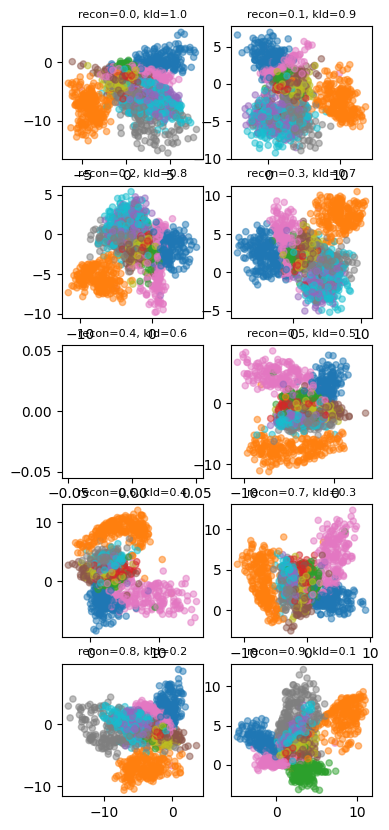

In [63]:
fig,axes=plt.subplots(5,2,figsize=(4,10))
axes=axes.ravel()

for (k,ax) in enumerate(axes):
    k1=k/nb_params
    k2=(nb_params-k)/nb_params
    avg=dic_models[k]["avg"]
    ax.scatter(avg[:,0],avg[:,1],c=test_labels,label=f"recon={k1}, kld={k2}",cmap='tab10', alpha=0.5, s=20)
    ax.set_title(f"recon={k1}, kld={k2}",size=8)#,fontdict={"fontsize":2})
plt.title

## Understanding the pb with model 2

In [96]:
modelPb=dic_models[4]["vae"]


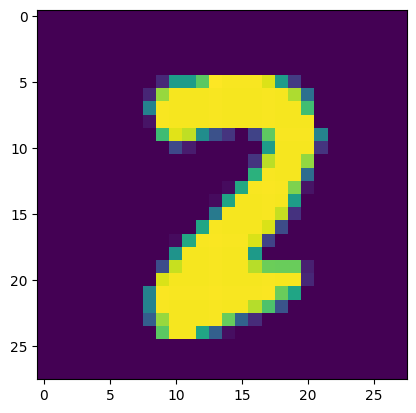

In [97]:
test_images.shape
image=test_images[10]
plt.imshow(image.detach().cpu().numpy().reshape(28,28))

In [98]:
mu,logvar=modelPb.encoder(image)
print(mu,"\n",logvar,"\n"*2)


tensor([[   nan, 0.0178]], device='mps:0', grad_fn=<LinearBackward0>) 
 tensor([[    nan, -0.0018]], device='mps:0', grad_fn=<LinearBackward0>) 




In [99]:
out, mu, log_var=modelPb(image)
print(mu,"\n",logvar)

tensor([[   nan, 0.0178]], device='mps:0', grad_fn=<LinearBackward0>) 
 tensor([[    nan, -0.0018]], device='mps:0', grad_fn=<LinearBackward0>)


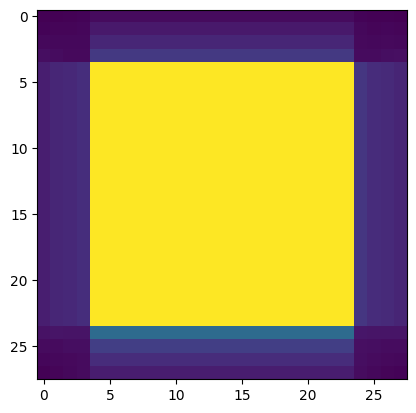

In [100]:
outIm=out.detach().cpu().numpy().reshape(28,28)
plt.imshow(outIm)

In [101]:
mod=np.load("../latent_space_view/latent_reco=0.4_kld=0.6.npy")

In [102]:
mod

array([[       nan, 0.01784241],
       [       nan, 0.01784241],
       [       nan, 0.01784241],
       ...,
       [       nan, 0.01784241],
       [       nan, 0.01784241],
       [       nan, 0.01784241]], dtype=float32)

In [107]:
k=4
modelPb=dic_models[k]["vae"]
modelPb.eval()
test_images=test_images.to(device)
# data = data.to(device)
# recon, mu, log_var = dic_models[k]["vae"](data)
with torch.no_grad():
    avg,_=dic_models[k]["vae"].encoder(test_images)
avg=avg.detach().cpu().numpy()
# dic_models[k]["avg"]=avg
# np.save(f"../latent_space_view/latent_reco={k1}_kld={k2}.npy")


In [108]:
avg

array([[       nan, 0.01784241],
       [       nan, 0.01784241],
       [       nan, 0.01784241],
       ...,
       [       nan, 0.01784241],
       [       nan, 0.01784241],
       [       nan, 0.01784241]], dtype=float32)